# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulation without noise

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from datetime import datetime
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import cmasher as cmm
import colorcet as cc
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from epics import ca
from matplotlib import gridspec

ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
mpl.rcParams.update({"font.size": 12, "text.usetex": False, "svg.fonttype": "none"})

In [5]:
cur_dir = Path.cwd().resolve()
save_dir = cur_dir / "nf_fwhm_pl_pi"
save_dir.mkdir(exist_ok=True)

### This is the analysis part

In [6]:
trials_file = save_dir / "trials.joblib"

In [7]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [8]:
base_out_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/sim_peak_fwhm_nlpi")
base_out_dir.mkdir(exist_ok=True)

In [9]:
out_dir = base_out_dir / "noise_free"
out_dir.mkdir(exist_ok=True)

In [10]:
ground_file = save_dir / "focused_beam.joblib"
ground_data = joblib.load(ground_file)

In [11]:
ground_dw = ground_data["dw"]
ground_hist = ground_data["hist"]

In [12]:
ground = {
    "FWHM": opt_common._get_fwhm_from_dw(ground_dw),
    "PL": opt_common._get_peak_distance_from_dw(ground_dw),
    "NLPI": -np.log(opt_common._get_peak_intensity_from_dw(ground_dw)),
}
ground

{'FWHM': 0.006426631246877412,
 'PL': 0.0010320434043324905,
 'NLPI': -4.31507379418668}

In [13]:
study = analysis.create_study_from_trials(trials_file, n_objectives=3)
n_steps = len(study.trials)

[I 2023-07-02 15:57:39,835] A new study created in memory with name: no-name-65890fae-2a73-484c-8a00-1d9b6ed32a86


Assuming minimization for all objectives.


In [14]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension="gz")

In [15]:
study.trials[0]

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.09281127900093358, 0.13749894414860853, -2.0649412631025577], datetime_start=datetime.datetime(2023, 6, 3, 15, 16, 59, 650720), datetime_complete=datetime.datetime(2023, 6, 3, 15, 17, 8, 327582), params={'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structures.DictionaryWrapper object at 0x7fb09155b6d0>, 'ws': 63.90154451520484}, system_attrs={'fixed_params': {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}, 'constraints': (-1,)}, intermediate_values={}, distributions={'hb_1': FloatDistribution(high=25.0, log=False, low=-25.0, step=None), 'hb_2': FloatDistribution(high=25.0, log=False, low=-25.0, step=None), 'hb_pitch': FloatDistribution(high=0.0019, log=False, low=-0.002, step=None), 'hb_trans': FloatDistribution(high=0.0299, log

In [16]:
maxcount = np.max(ground_hist.data_2D)
maxcount2 = np.max([h.data_2D for h in hists])

In [17]:
maxcount = np.maximum(maxcount, maxcount2)

In [18]:
m2 = apu.CMAP

{'h_sigma': 0.0021526273921479806, 'h_fwhm': 0.005877209302325603, 'h_centroid': -5.326033546912119e-05, 'h_peak': -0.0009795348837209339, 'v_sigma': 0.0018024980787885955, 'v_fwhm': 0.0025999999999997137, 'v_centroid': -0.0017251616322859753, 'v_peak': 0.0003250000000000197, 'integral_intensity': 3459.687821961541, 'peak_intensity': 74.81914445814444, 'gaussian_fit': {}}


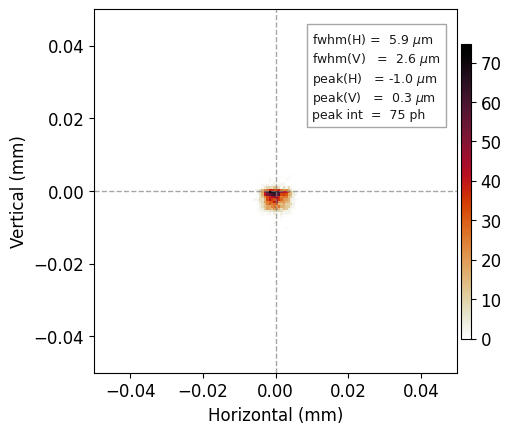

In [19]:
dwd = dict(ground_dw._DictionaryWrapper__dictionary)
print(dwd)
hist = ground_hist
plt.figure(figsize=[5, 5], constrained_layout=True)
ax = plt.gca()

plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, rasterized=True)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)
# ax.set_yticklabels([])


ax.set_aspect("equal")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.6,
    0.7,
    text,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=ax.transAxes,
)
plt.savefig(f"{out_dir}/focussed.svg", bbox_inches="tight", dpi=600)
# plt.title('Initial')
plt.show()

Trial number 0
Trial values: peak_distance 1.375e-01 fwhm 9.281e-02 int -2.065e+00
Trial dw:
{'h_sigma': 0.03522430514479599, 'h_fwhm': 0.09272930232558174, 'h_centroid': -0.13146585068242483, 'h_peak': -0.13615534883720937, 'v_sigma': 0.010211332254344998, 'v_fwhm': 0.0038999999999995705, 'v_centroid': 0.018530876183051638, 'v_peak': -0.019174999999999942, 'integral_intensity': 3368.258555559202, 'peak_intensity': 7.8848347533229495, 'gaussian_fit': {}}
Actual fwhm 0.09281127900093358


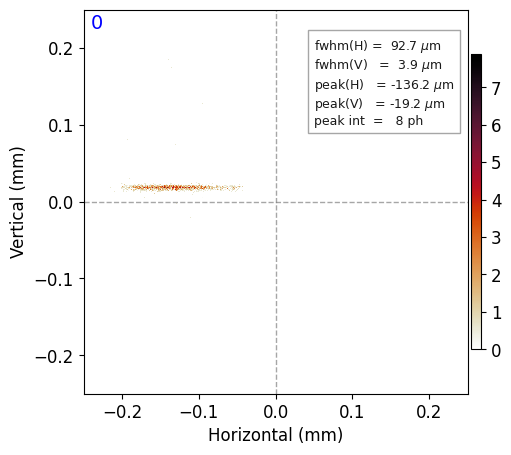

In [20]:
t = study.trials[0]
print("Trial number", t.number)
print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e} int {t.values[2]:4.3e}")
print("Trial dw:")

dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
print(dwd)
print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
hist = hists[t.number]
plt.figure(figsize=[5, 5], constrained_layout=True)
ax = plt.gca()

plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, rasterized=True)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)
# ax.set_yticklabels([])


ax.set_aspect("equal")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.6,
    0.7,
    text,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=ax.transAxes,
)
plt.text(0.02, 0.95, 0, fontsize=14, color="blue", transform=ax.transAxes)
plt.savefig(f"{out_dir}/initial.svg", bbox_inches="tight", dpi=600)
# plt.title('Initial')
plt.show()

In [21]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [22]:
nash_trial

FrozenTrial(number=93, state=TrialState.COMPLETE, values=[0.006019268160112343, 0.003349756868634153, -3.682248214087854], datetime_start=datetime.datetime(2023, 6, 3, 15, 46, 55, 951306), datetime_complete=datetime.datetime(2023, 6, 3, 15, 47, 20, 278800), params={'hb_1': -14.0, 'hb_2': 15.0, 'hb_pitch': -0.0013, 'hb_trans': 0.014000000000000005, 'vb_bender': -4.0, 'vb_pitch': 0.0015600000000000002, 'vb_trans': -0.006699999999999998}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structures.DictionaryWrapper object at 0x7fb0a1226430>, 'ws': 0.6627982423800602}, system_attrs={'constraints': (-1,)}, intermediate_values={}, distributions={'hb_1': FloatDistribution(high=25.0, log=False, low=-25.0, step=None), 'hb_2': FloatDistribution(high=25.0, log=False, low=-25.0, step=None), 'hb_pitch': FloatDistribution(high=0.0019, log=False, low=-0.002, step=None), 'hb_trans': FloatDistribution(high=0.0299, log=False, low=-0.03, step=None), 'vb_bender': FloatDistribution(hig

In [34]:
ground_mots = {'hb_1': -145, 'hb_2': -175, 'hb_pitch': 0.1706, 'hb_trans': -0.042, 'vb_bender': 419.5, 'vb_pitch': 0.1704, 'vb_trans': 0.0113}

Trial number 22
Trial values: peak_distance 1.897e-03 fwhm 2.485e-02 int -3.045e+00
Trial dw:
{'h_sigma': 0.01724325287277128, 'h_fwhm': 0.024814883720930325, 'h_centroid': -0.0022126008824955093, 'h_peak': 0.0009795348837209339, 'v_sigma': 0.0036893695479252486, 'v_fwhm': 0.0012999999999998568, 'v_centroid': -0.0011142875270126148, 'v_peak': -0.0016249999999999876, 'integral_intensity': 3446.6669982253384, 'peak_intensity': 21.007590579603896, 'gaussian_fit': {}}
Trial mots
{'hb_1': -155.0, 'hb_2': -156.0, 'hb_pitch': 0.1693, 'hb_trans': -0.030100000000000002, 'vb_bender': 415.5, 'vb_pitch': 0.17194, 'vb_trans': 0.007400000000000002}


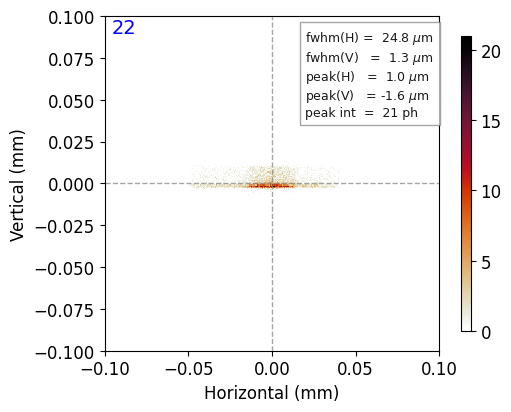

Trial number 35
Trial values: peak_distance 6.781e-02 fwhm 5.384e-03 int -3.312e+00
Trial dw:
{'h_sigma': 0.024519898956985534, 'h_fwhm': 0.005224186046511647, 'h_centroid': 0.043841336484043994, 'h_peak': 0.06758790697674422, 'v_sigma': 0.003616630415419267, 'v_fwhm': 0.0012999999999998568, 'v_centroid': 0.002726026704582269, 'v_peak': -0.005525000000000002, 'integral_intensity': 3235.982797411228, 'peak_intensity': 27.45096074382505, 'gaussian_fit': {}}
Trial mots
{'hb_1': -168.0, 'hb_2': -166.0, 'hb_pitch': 0.1691, 'hb_trans': -0.0572, 'vb_bender': 415.5, 'vb_pitch': 0.17188, 'vb_trans': 0.006400000000000001}


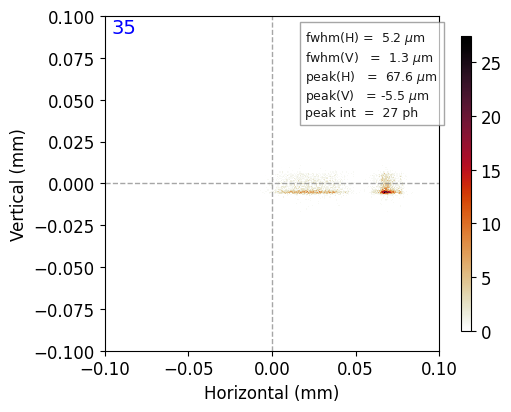

Trial number 62
Trial values: peak_distance 1.897e-03 fwhm 7.029e-03 int -4.094e+00
Trial dw:
{'h_sigma': 0.0027668807686000657, 'h_fwhm': 0.006530232558139559, 'h_centroid': -7.875510229277474e-05, 'h_peak': 0.0009795348837209339, 'v_sigma': 0.0019770667764396274, 'v_fwhm': 0.0025999999999997137, 'v_centroid': -0.0029244937161820033, 'v_peak': 0.001625000000000043, 'integral_intensity': 3432.5036594759754, 'peak_intensity': 59.96142738083832, 'gaussian_fit': {}}
Trial mots
{'hb_1': -167.0, 'hb_2': -159.0, 'hb_pitch': 0.1693, 'hb_trans': -0.031599999999999996, 'vb_bender': 418.5, 'vb_pitch': 0.17174, 'vb_trans': -0.0112}


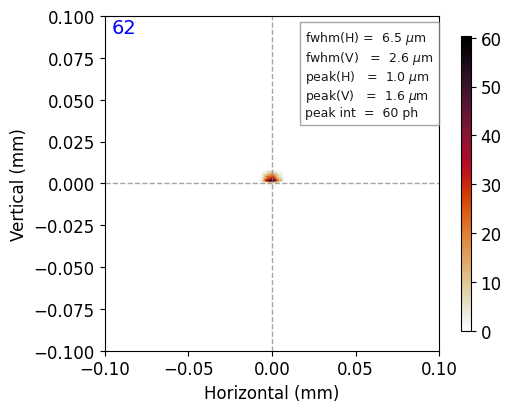

Trial number 93
Trial values: peak_distance 3.350e-03 fwhm 6.019e-03 int -3.682e+00
Trial dw:
{'h_sigma': 0.011653295322777679, 'h_fwhm': 0.005877209302325603, 'h_centroid': -0.0036569953078394294, 'h_peak': -0.0016325581395348898, 'v_sigma': 0.003611273385044828, 'v_fwhm': 0.0012999999999998568, 'v_centroid': -0.005354923215528294, 'v_peak': 0.002925000000000011, 'integral_intensity': 3472.1583606785466, 'peak_intensity': 39.73562792507553, 'gaussian_fit': {}}
Trial mots
{'hb_1': -159.0, 'hb_2': -160.0, 'hb_pitch': 0.1693, 'hb_trans': -0.027999999999999997, 'vb_bender': 415.5, 'vb_pitch': 0.17196, 'vb_trans': 0.004600000000000002}


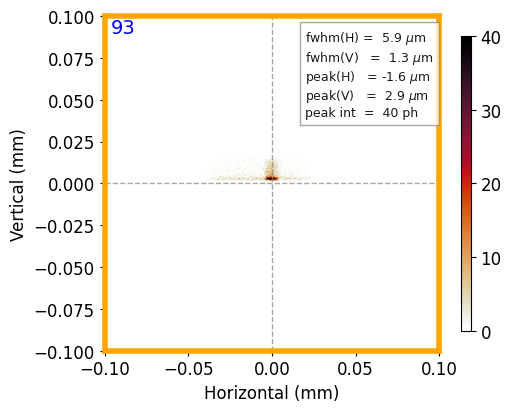

Trial number 96
Trial values: peak_distance 1.658e-02 fwhm 6.427e-03 int -3.793e+00
Trial dw:
{'h_sigma': 0.014151011188580136, 'h_fwhm': 0.005877209302325603, 'h_centroid': -0.00835472513592746, 'h_peak': 0.00032651162790697796, 'v_sigma': 0.0019275066929225818, 'v_fwhm': 0.0025999999999997137, 'v_centroid': 0.01564628291978454, 'v_peak': -0.016575000000000006, 'integral_intensity': 3374.3230544338576, 'peak_intensity': 44.38829131876114, 'gaussian_fit': {}}
Trial mots
{'hb_1': -159.0, 'hb_2': -160.0, 'hb_pitch': 0.1693, 'hb_trans': -0.022699999999999998, 'vb_bender': 419.5, 'vb_pitch': 0.17192, 'vb_trans': 0.0228}


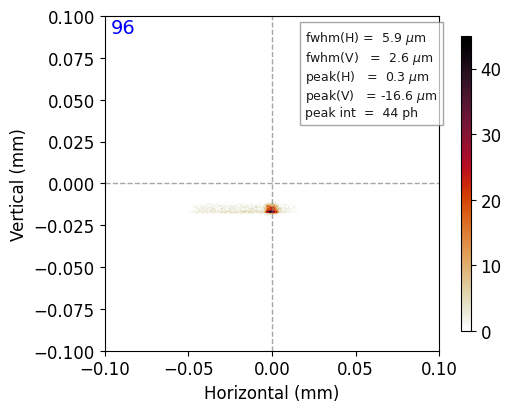

In [35]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e} int {t.values[2]:4.3e}")
    print("Trial dw:")
    
    dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dwd)

    print('Trial mots')
    print({m: ground_mots[m] + v for m,v in t.params.items()})
    
    plt.figure(figsize=[5, 5], constrained_layout=True)
    plt.pcolormesh(
        hists[t.number].hh,
        hists[t.number].vv,
        hists[t.number].data_2D.T[::-1],
        cmap=m2,
        rasterized=True,
    )
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)
    plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
    plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
    plt.xlabel("Horizontal (mm)")
    plt.ylabel("Vertical (mm)")
    # plt.title(t.number)
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect("equal")

    text = (
        rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak int':<9} = {dwd['peak_intensity']: 3.0f} ph"
    )
    ax.text(
        0.6,
        0.7,
        text,
        color="black",
        alpha=0.9,
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
        transform=ax.transAxes,
    )
    
    plt.text(0.02, 0.95, t.number, fontsize=14, color="blue", transform=ax.transAxes)
    plt.savefig(f"{out_dir}/pareto_{t.number}.svg", bbox_inches="tight", dpi=600)
    if t.number == nash_trial.number:
        for axis in ["top", "bottom", "left", "right"]:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color("orange")
    plt.show()

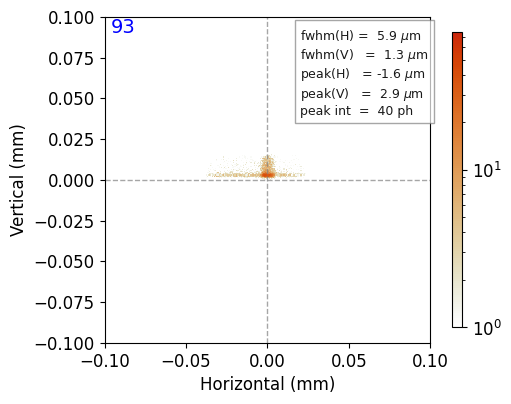

In [45]:
tnum = nash_trial.number
dwd = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)

hist = hists[tnum]
plt.figure(figsize=[5, 5], constrained_layout=True)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T[::-1], cmap=m2, norm=mpl.colors.LogNorm(1, maxcount), rasterized=True)
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
# plt.title(t.number)
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect("equal")


text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.6,
    0.7,
    text,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=ax.transAxes,
)
plt.text(0.02, 0.95, tnum, fontsize=14, color="blue", transform=ax.transAxes)
plt.savefig(f"{out_dir}/pareto_hh.svg", bbox_inches="tight", dpi=600)
plt.show()

In [46]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]

In [47]:
c2

[22, 35, 62, 96]

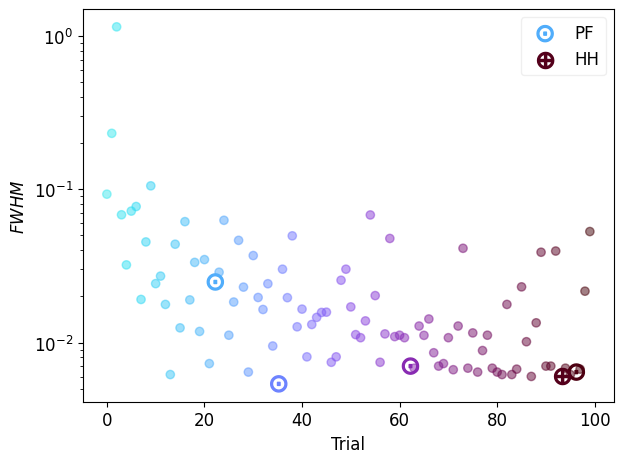

In [48]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values


plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="HH"
)

plt.xlabel("Trial")
plt.ylabel("$FWHM$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

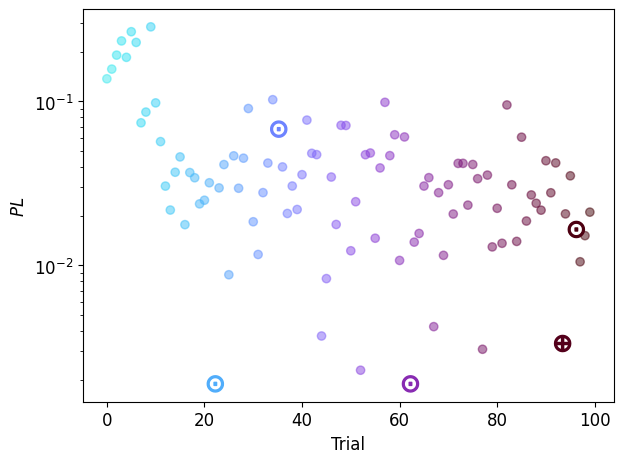

In [49]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[1] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$PL$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.tight_layout()
plt.show()

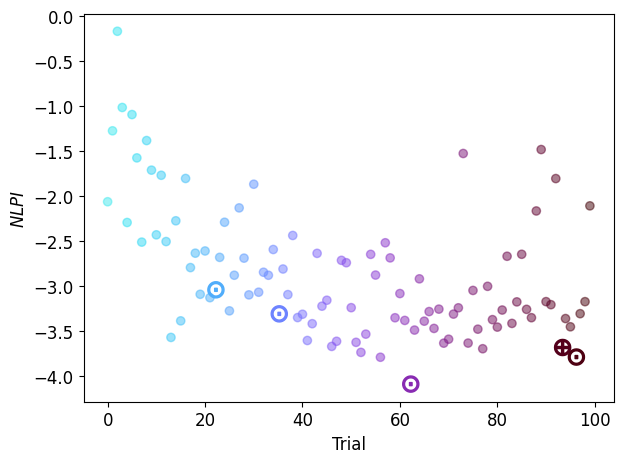

In [50]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$NLPI$")
plt.tight_layout()
plt.show()

In [22]:
ground

{'FWHM': 0.006426631246877412,
 'PL': 0.0010320434043324905,
 'NLPI': -4.31507379418668}

In [23]:
out_dir

PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/sim_peak_fwhm_nlpi/noise_free')

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_6504/4254020698.py:29: MatplotlibDeprecationWarning: The execute_constrained_layout function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.get_layout_engine().execute() instead.
  fig.execute_constrained_layout()


4.462583681393228 4.352882222222223


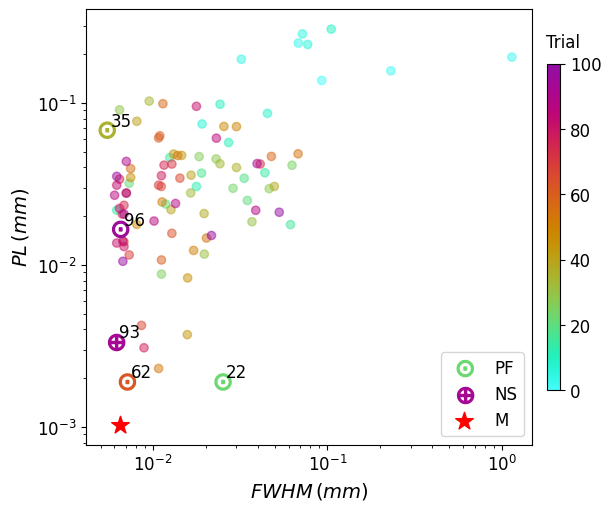

In [53]:
x = np.array([t.values[0] for t in study.trials])
y = np.array([t.values[1] for t in study.trials])

fig = plt.figure(figsize=[6, 5], constrained_layout=True)
plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

for t in study.best_trials:
    plt.annotate(t.number, xy=(x[t.number], y[t.number]), xytext=(3, 3), textcoords="offset points")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$FWHM\,(mm)$", fontsize=14)
plt.ylabel("$PL\,(mm)$", fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location="right")
# cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 105.0, "Trial")
# cbar.ax.set_xlabel('Trial')#, fontsize=14)

plt.scatter(ground["FWHM"], ground["PL"], color="red", marker="*", s=175, label="M")
plt.legend(loc="best")
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
plt.savefig(f"{out_dir}/pareto_fwhm_pl.svg", bbox_inches="tight", dpi=600)
plt.show()

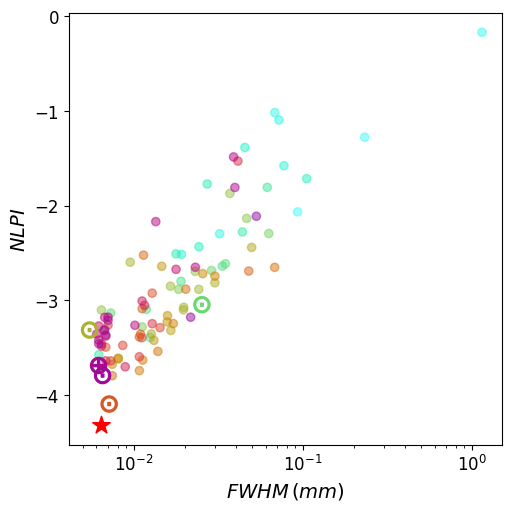

In [54]:
plt.figure(figsize=[5, 5], constrained_layout=True)
x = np.array([t.values[0] for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)
plt.xscale("log")
# plt.yscale('log')
plt.xlabel("$FWHM\, (mm)$", fontsize=14)
plt.ylabel("$NLPI$", fontsize=14)

plt.scatter(ground["FWHM"], ground["NLPI"], color="red", marker="*", s=175, label="M")
# plt.legend(loc='best')
# plt.tight_layout()

plt.savefig(f"{out_dir}/pareto_fwhm_nlpi.svg", bbox_inches="tight", dpi=600)
plt.show()

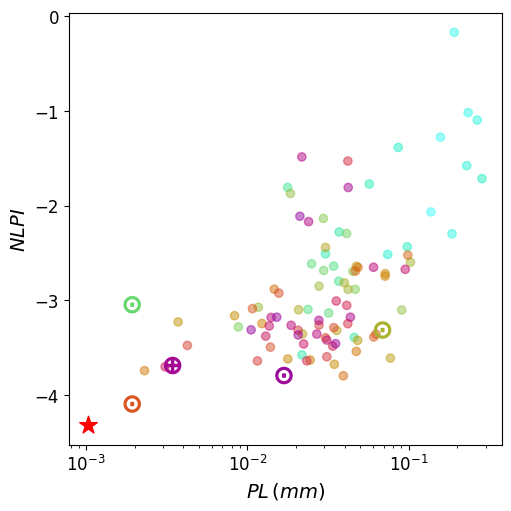

In [55]:
plt.figure(figsize=[5, 5], constrained_layout=True)
x = np.array([t.values[1] for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)
plt.xscale("log")
# plt.yscale('log')
plt.xlabel("$PL\,(mm)$", fontsize=14)
plt.ylabel("$NLPI$", fontsize=14)

plt.scatter(ground["PL"], ground["NLPI"], color="red", marker="*", s=175, label="M")
# plt.legend(loc='best')
# plt.tight_layout()

plt.savefig(f"{out_dir}/pareto_pl_nlpi.svg", bbox_inches="tight", dpi=600)
plt.show()

### Combining the figures into one

In [24]:
props = apu.AnalyzedProps(study, nash_trial, max_count=maxcount, min_count=1, xylim=0.1, photon_count_str="3.0f")

In [25]:
nash_idx, nash_trial.number

(3, 93)

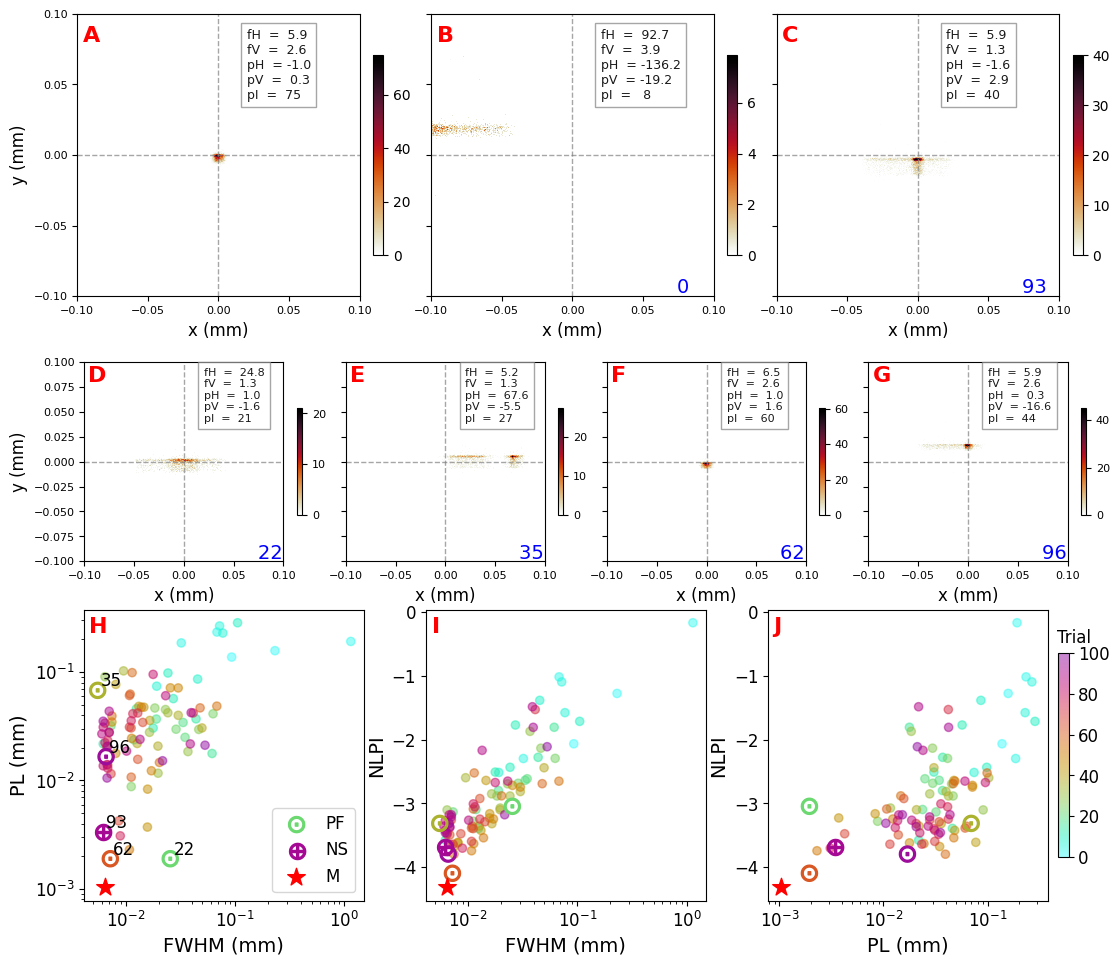

In [26]:
fig = plt.figure(figsize=[11, 10], layout="constrained")
gs0 = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[0.4, 0.25, 0.35])


# top row
gss0 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0])

axs0 = gss0.subplots(sharex=True, sharey=True)


cmesh0, sublabel = apu.plot_hist_2d(props, axs0[0], ground_hist, ylabel=True)
apu.add_text_to_hist(props, axs0[0], ground_dw)


cmesh1, sublabel = apu.plot_hist_2d(props, axs0[1], hists[0], study_num=0, sublabel=sublabel)
apu.add_text_to_hist(props, axs0[1], study.trials[0].user_attrs["dw"])

cmesh2, sublabel = apu.plot_hist_2d(props, axs0[2], hists[nash_trial.number], study_num=nash_trial.number, sublabel=sublabel)
apu.add_text_to_hist(props, axs0[2], study.trials[nash_trial.number].user_attrs["dw"])
# _, sublabel = apu.

for ix, cmesh in enumerate([cmesh0, cmesh1, cmesh2]):
    cbar = fig.colorbar(cmesh, ax=axs0[ix], pad=0.005, shrink=0.5)
    cbar.ax.tick_params(labelsize=10)
    axs0[ix].locator_params(nbins=4)

# middle row
gss1 = gridspec.GridSpecFromSubplotSpec(1, len(study.best_trials) - 1, subplot_spec=gs0[1])

axs1 = gss1.subplots(sharex=True, sharey=True)

_trials = [t for t in study.best_trials if t.number != nash_trial.number]

for ix, t in enumerate(_trials):

    ylabel = True if ix == 0 else False
    cmesh, sublabel = apu.plot_hist_2d(
        props, axs1[ix], hists[t.number], study_num=t.number, sublabel=sublabel, ylabel=ylabel
    )
    apu.add_text_to_hist(props, axs1[ix], dw=t.user_attrs["dw"], fontsize=8)
    cbar = fig.colorbar(cmesh, ax=axs1[ix], pad=0.005, shrink=0.5)
    cbar.ax.tick_params(labelsize=8)

# bottom row

gss2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2])
axs2 = gss2.subplots()

cscatter, sublabel = apu.plot_pareto_2d(
    props, axs2[0], "FWHM", "PL", sublabel=sublabel, ground=ground, annotate=True, legend=True
)
_, sublabel = apu.plot_pareto_2d(props, axs2[1], "FWHM", "NLPI", sublabel=sublabel, ground=ground)
_, sublabel = apu.plot_pareto_2d(props, axs2[2], "PL", "NLPI", sublabel=sublabel, ground=ground)

cbar = plt.colorbar(cscatter, ax=axs2, pad=0.01, shrink=0.7, location="right")
cbar.ax.text(-0.1, 105.0, "Trial")

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0.05, wspace=0.01)
plt.savefig(f"{out_dir}/fig_combined.pdf", bbox_inches="tight", dpi=600)
plt.show()